In [1]:
import neurokit2 as nk
from scipy import signal, stats

from scipy.signal import find_peaks, savgol_filter
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# import neurokit2 as nk
from tqdm import tqdm
import pandas as pd
import numpy as np
import umap
import h5py

import torch.optim as optim
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import DataLoader, TensorDataset, random_split

import warnings
warnings.filterwarnings("ignore")

In [2]:
device='cpu'

In [3]:
class AttentionLayer(nn.Module):
    """Механизм внимания для временных рядов."""
    def __init__(self, hidden_dim):
        super().__init__()
        self.query = nn.Linear(hidden_dim, hidden_dim)
        self.key = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x):
        # x: (batch, seq_len, hidden_dim)
        Q = self.query(x)
        K = self.key(x)
        scores = torch.matmul(Q, K.transpose(1, 2)) / torch.sqrt(torch.tensor(x.shape[-1]))
        weights = torch.softmax(scores, dim=-1)
        return torch.matmul(weights, x)

class ECGEncoder(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64):
        super().__init__()
        self.conv1 = nn.Conv1d(input_dim, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.lstm = nn.LSTM(64, hidden_dim, batch_first=True)
        self.attention = AttentionLayer(hidden_dim)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, 1, seq_len) -> (batch, channels, seq_len)
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.permute(0, 2, 1)  # (batch, seq_len, channels)
        x, _ = self.lstm(x)
        x = self.attention(x)
        return x

class ECGDecoder(nn.Module):
    def __init__(self, hidden_dim=64, output_dim=1):
        super().__init__()
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.upconv1 = nn.ConvTranspose1d(
            hidden_dim, 32, 
            kernel_size=3, 
            stride=2,
            output_padding=1
        )
        self.upconv2 = nn.ConvTranspose1d(
            32, output_dim, 
            kernel_size=5, 
            stride=2,
            padding=2,
            output_padding=1
        )
        
    def forward(self, x):
        x, _ = self.lstm(x)
        x = x.permute(0, 2, 1)
        x = torch.relu(self.upconv1(x))
        # x = torch.tanh(self.upconv2(x))  # <- tanh вместо sigmoid
        x = self.upconv2(x)
        return x.permute(0, 2, 1)[:, :5000, :]

class ECGAutoencoder(nn.Module):
    def __init__(self, input_channels=1):
        super().__init__()
        self.encoder = ECGEncoder(input_dim=input_channels)
        self.decoder = ECGDecoder(output_dim=input_channels)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def get_embeddings(self, x):
        with torch.no_grad():
            return self.encoder(x)

In [4]:
def ultra_filter(signals, n=None, channel=None):
    if n == None and channel==None:
        y = signals
    else:
        y = signals[n][channel]

    # 1. Найдем пики
    peaks, _ = find_peaks(y, height=(0.1, 0.5), distance=10)
    peaks = peaks[peaks < len(y)]

    # 2. Найдем тренд с помощью фильтра Савицкого-Голея
    y_trend = savgol_filter(y, window_length=51, polyorder=3)

    # 3. Удалим тренд, чтобы получить колебания (пики и волны)
    y_fluctuations = y - y_trend

    # 4. Обработаем волны (сгладим их)
    y_waves_smoothed = savgol_filter(y_fluctuations, window_length=21, polyorder=2)

    # 5. Восстановим данные, добавив колебания к тренду
    y_restored = y_trend + y_waves_smoothed

    return y_restored

def signal_transform_tensor_1(signals, N=0, max_len_signal=5000, sampling_rate=500):
    """Транформирует сигналы в тензор.\n
    N - номер отведения в соответствии с массивом:\n
    ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']"""

    # Ограничиваем максимальную длину до единого значения для использования в батче.
    # Дописывать нули в конце для одной длины - сомнительная идея для LSTM.

    i = 0

    result_reshape = np.reshape([ultra_filter([float(ss) for ss in signal[i][0:max_len_signal]]) for signal in signals], (1, max_len_signal * len(signals)))
    # result_reshape = np.reshape([[float(ss) for ss in signal[i][0:max_len_signal]] for signal in signals], (1, max_len_signal * len(signals)))

    return torch.tensor(result_reshape, dtype=torch.float32).reshape((1, len(signals), max_len_signal)).permute((1,2,0))

def signal_transform_tensor_1_non_fixed(signals, N=0, sampling_rate=500):
    """Транформирует сигналы в тензор.\n
    N - номер отведения в соответствии с массивом:\n
    ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']"""

    # Ограничиваем максимальную длину до единого значения для использования в батче.
    # Дописывать нули в конце для одной длины - сомнительная идея для LSTM.

    i = 0

    res = []

    for signal in signals:
        res.append(torch.tensor(ultra_filter([float(ss) for ss in signal[i]]), dtype=torch.float32))
    
    return res

    # result_reshape = np.reshape([ultra_filter([float(ss) for ss in signal[i]]) for signal in signals], (1, max_len_signal * len(signals)))
    # # result_reshape = np.reshape([[float(ss) for ss in signal[i][0:max_len_signal]] for signal in signals], (1, max_len_signal * len(signals)))

    # return torch.tensor(result_reshape, dtype=torch.float32).reshape((1, len(signals), max_len_signal)).permute((1,2,0))

def label_transform_tensor(labels, all_diagnoses=False):
    """Транформирует лейблы в тензор.\n
    Сейчас только в режиме 'Норма-Не норма'."""

    # TODO: сделать разбиение лейблов на первичное и вторичное заключение врача

    result_labels = []

    if all_diagnoses:
        return None
    
    else:
        # Норма - Не норма
        for label in labels:
            if label == '1':
                result_labels.append(0)
            else:
                result_labels.append(1)

    result_labels = torch.tensor(result_labels, dtype=torch.float32).reshape((len(result_labels), 1))

    print("Label transformed to tensor successfully\n")

    return result_labels

def ecg_quality_metrics(signal, fs=1000):
    # Очистка сигнала
    cleaned = nk.ecg_clean(signal, sampling_rate=fs)
    
    # Детекция R-пиков
    r_peaks = nk.ecg_findpeaks(cleaned, sampling_rate=fs)['ECG_R_Peaks']
    
    # Расчет SNR
    noise = signal - cleaned
    snr = 10 * np.log10(np.var(cleaned) / np.var(noise))
    
    # Стабильность RR-интервалов
    rr = np.diff(r_peaks) / fs * 1000  # в мс
    cv_rr = (np.std(rr) / np.mean(rr)) * 100  # Коэффициент вариации
    
    # return {"SNR_dB": snr, "RR_CV%": cv_rr}
    return snr, cv_rr

def ecg_quality_metrics_ultra(signal, fs=1000):
    # Очистка сигнала
    cleaned = ultra_filter(signal)
    
    # Детекция R-пиков
    r_peaks = nk.ecg_findpeaks(cleaned, sampling_rate=fs)['ECG_R_Peaks']
    
    # Расчет SNR
    noise = signal - cleaned
    snr = 10 * np.log10(np.var(cleaned) / np.var(noise))
    
    # Стабильность RR-интервалов
    rr = np.diff(r_peaks) / fs * 1000  # в мс
    cv_rr = (np.std(rr) / np.mean(rr)) * 100  # Коэффициент вариации
    
    # return {"SNR_dB": snr, "RR_CV%": cv_rr}
    return snr, cv_rr

def load_data(metadata_filepath='metadata.csv', N_start=0, N_end=10, only_health=False):
    """Загрузка данных из файлов.\n
    Работает только при наличии директории 'records',\n
    в которой пять папок по 5000 файлов записей"""
    
    # Загружаем метаданные и выбираем срезом нужные
    metadata_full = pd.read_csv(metadata_filepath)
    metadata = metadata_full.iloc[N_start:N_end]

    # Убираем лишние столбцы, приводим к типу int32
    metadata = metadata.drop(columns=['Date', 'Patient_ID'])
    metadata['Age'].astype(np.int32)
    metadata['N'].astype(np.int32)

    if only_health:
        # Берём только здоровых людей
        health_metadata = metadata.loc[metadata['AHA_Code'] == '1']
        id_metadata = health_metadata['ECG_ID'].values
        labels = health_metadata['AHA_Code'].values
    else:
        # Берём всех
        id_metadata = metadata['ECG_ID'].values
        labels = metadata['AHA_Code'].values

    signals = []

    for i in id_metadata:
        # Из Axxxxx оставляем численную часть
        number = int(i[1:])

        # В каждой папке 5000 файлов (кроме пятой), поэтому,
        # чтобы узнать номер папки, в которой запись, делим на 5000
        record_num = (number - 1) // 5000
        if record_num > 4:
            record_num = 4
        record_num = record_num + 1
        
        # Считываем файл.
        if record_num == 1:
            file_name_ = f'../records/record{record_num}/{i}.h5'
        else:
            file_name_ = f'../records/records{record_num}/{i}.h5'
        with h5py.File(file_name_, 'r') as f:
            signals.append(f['ecg'][()])
    
    health_n = len(labels[labels == '1'])
    diseased_n = len(labels[labels != '1'])

    print(f"Data loaded successfully.\n\
          Health    number:     {health_n}\n\
          Diseased  number:     {diseased_n}\n\n")

    return signals, labels

def load_data_age_sex(metadata_filepath='metadata.csv', N_start=0, N_end=10, only_health=False):
    """Загрузка данных из файлов.\n
    Работает только при наличии директории 'records',\n
    в которой пять папок по 5000 файлов записей"""
    
    # Загружаем метаданные и выбираем срезом нужные
    metadata_full = pd.read_csv(metadata_filepath)
    metadata = metadata_full.iloc[N_start:N_end]

    # Убираем лишние столбцы, приводим к типу int32
    metadata = metadata.drop(columns=['Date', 'Patient_ID'])
    metadata['Age'].astype(np.int32)
    metadata['N'].astype(np.int32)

    metadata['Sex'].replace({'M': 0, 'F': 1}, inplace=True)

    if only_health:
        # Берём только здоровых людей
        health_metadata = metadata.loc[metadata['AHA_Code'] == '1']
        id_metadata = health_metadata['ECG_ID'].values
        labels = health_metadata['AHA_Code'].values
        ages = health_metadata['Age'].values
        sexs = health_metadata['Sex'].values
    else:
        # Берём всех
        id_metadata = metadata['ECG_ID'].values
        labels = metadata['AHA_Code'].values
        ages = metadata['Age'].values
        sexs = metadata['Sex'].values

    signals = []

    for i in id_metadata:
        # Из Axxxxx оставляем численную часть
        number = int(i[1:])

        # В каждой папке 5000 файлов (кроме пятой), поэтому,
        # чтобы узнать номер папки, в которой запись, делим на 5000
        record_num = (number - 1) // 5000
        if record_num > 4:
            record_num = 4
        record_num = record_num + 1
        
        # Считываем файл.
        if record_num == 1:
            file_name_ = f'../records/record{record_num}/{i}.h5'
        else:
            file_name_ = f'../records/records{record_num}/{i}.h5'
        with h5py.File(file_name_, 'r') as f:
            signals.append(f['ecg'][()])
    
    health_n = len(labels[labels == '1'])
    diseased_n = len(labels[labels != '1'])

    print(f"Data loaded successfully.\n\
          Health    number:     {health_n}\n\
          Diseased  number:     {diseased_n}\n\n")

    return signals, labels, ages, sexs

def delete_bad_snr_db(signals_, labels_, channel_check=0, print_idx=False):
    signals = []
    labels = []
    deleted_idx = []
    ok_idx = []
    
    for i in range(len(signals_)):
        sbr_db, rr = ecg_quality_metrics_ultra(signals_[i][channel_check], 500)
        
        if sbr_db >= 15:
            signals.append(signals_[i])
            labels.append(labels_[i])
            ok_idx.append(i)
        else:
            deleted_idx.append(i)
    
    if print_idx:
        print("deleted indexes:")
        print(*deleted_idx)
    
    print(f"num of left: {len(signals)}")
    
    return signals, labels, ok_idx

def delete_bad_snr_db_ages_sexs(signals_, labels_, ages_=None, sexs_=None, channel_check=0, print_idx=False):
    signals = []
    labels = []
    ages = []
    sexs = []
    deleted_idx = []
    
    for i in range(len(signals_)):
        sbr_db, rr = ecg_quality_metrics_ultra(signals_[i][channel_check], 500)
        
        if sbr_db >= 15:
            signals.append(signals_[i])
            labels.append(labels_[i])
            ages.append(ages_[i])
            sexs.append(sexs_[i])
        else:
            deleted_idx.append(i)
    
    if print_idx:
        print("deleted indexes:")
        print(*deleted_idx)
    
    print(f"num of left: {len(signals)}")
    
    return signals, labels, ages, sexs

def load_markers(npz_path):
    """
    Загружает разметку из NPZ-файла
    Возвращает словарь с:
    - 'files': список имен файлов
    - 'markers': список словарей с маркерами для каждого файла
    - 'sample_rate': частота дискретизации
    """
    data = np.load(npz_path, allow_pickle=True)
    
    result = {
        'files': list(data['files']),
        'markers': list(data['markers']),
        'sample_rate': int(data.get('sample_rate', 500))  # По умолчанию 500 Гц
    }
    
    return result

In [113]:
def split_into_windows(data, labels_, r_reaks, shift=0, auto_dop=0):
    windows = []
    scaler = StandardScaler()

    labels_ = labels_.flatten()

    labels = []
    
    for i in range(len(data)):
        for j in range(len(r_reaks[i]['R']) - 1):
            if r_reaks[i]['R'][j] != r_reaks[i]['R'][j + 1]:
                res = scaler.fit_transform(data[i][r_reaks[i]['R'][j] - shift:r_reaks[i]['R'][j + 1] - shift].reshape(-1, 1)).reshape(-1).tolist()
                for g in range(len(res), auto_dop):
                    res.append(res[-1])
                windows.append(res)
                labels.append(labels_[i])

    result = []
    for i in range(len(windows)):
        # print(torch.tensor(windows[i]).reshape((1, len(windows[i]), 1)).shape)
        result.append(torch.tensor(windows[i]).reshape((1, len(windows[i]), 1)))

    return result, labels

In [43]:
def umaper(model, x_data, y_data, n_components=2, alpha=0.3):
    model.eval()

    with torch.no_grad():
        embeddings = model.get_embeddings(x_data).numpy()
        print(embeddings.shape)
    
    embeddings_avg = embeddings.mean(axis=1)
    reducer = umap.UMAP(n_components=n_components)
    embeddings_2d = reducer.fit_transform(embeddings_avg)

    num = [331, 332, 333, 334, 335, 336, 337, 338, 339]
    k = 0

    print("UMAP, average")
    for i in range(n_components):
        for j in range(i, n_components):
            if k >= 9:
                k = 0
                plt.show()
                plt.figure()
            plt.subplot(num[k])

            plt.scatter(
                embeddings_2d[:, i], 
                embeddings_2d[:, j],
                c=y_data,  # Цвета по y_data
                cmap="viridis",
                alpha=alpha
            )
            plt.xlabel(f"feature_{i}")
            plt.ylabel(f"feature_{j}")
            k += 1
    
    if k != 9:
        plt.show()
    
    k = 0

    embeddings_flatten = embeddings.reshape(embeddings.shape[0], -1)

    reducer = umap.UMAP(n_components=n_components)
    embeddings_2d = reducer.fit_transform(embeddings_flatten)

    print("UMAP, flatten")
    for i in range(n_components):
        for j in range(i, n_components):
            if k >= 9:
                k = 0
                plt.show()
                plt.figure()
            plt.subplot(num[k])

            plt.scatter(
                embeddings_2d[:, i], 
                embeddings_2d[:, j],
                c=y_data,  # Цвета по y_data
                cmap="viridis",
                alpha=alpha
            )
            plt.xlabel(f"feature_{i}")
            plt.ylabel(f"feature_{j}")
            k += 1

In [53]:
def umaper_new(model, x_data, y_data, n_components=2, alpha=0.3):
    model.eval()

    embeddings = []

    # print(len(x_data))

    with torch.no_grad():
        for data in x_data:
            # print(model.get_embeddings(data).numpy().shape)
            damn_data = model.get_embeddings(data).numpy()
            # print(model.get_embeddings(data).numpy().shape)
            embeddings.append(damn_data.mean(axis=1)[0])
            
    embeddings_avg = np.array(embeddings)
    reducer = umap.UMAP(n_components=n_components)
    embeddings_2d = reducer.fit_transform(embeddings_avg)

    num = [331, 332, 333, 334, 335, 336, 337, 338, 339]
    k = 0

    print("UMAP, average")
    for i in range(n_components):
        for j in range(i, n_components):
            if k >= 9:
                k = 0
                plt.show()
                plt.figure()
            plt.subplot(num[k])

            plt.scatter(
                embeddings_2d[:, i], 
                embeddings_2d[:, j],
                c=y_data,  # Цвета по y_data
                cmap="viridis",
                alpha=alpha
            )
            plt.xlabel(f"feature_{i}")
            plt.ylabel(f"feature_{j}")
            k += 1
    
    if k != 9:
        plt.show()
    
    return reducer

    # embeddings_flatten = embeddings.reshape(embeddings.shape[0], -1)

    # reducer = umap.UMAP(n_components=n_components)
    # embeddings_2d = reducer.fit_transform(embeddings_flatten)

    # print("UMAP, flatten")
    # for i in range(n_components):
    #     for j in range(i, n_components):
    #         if k >= 9:
    #             k = 0
    #             plt.show()
    #             plt.figure()
    #         plt.subplot(num[k])

    #         plt.scatter(
    #             embeddings_2d[:, i], 
    #             embeddings_2d[:, j],
    #             # c=y_data,  # Цвета по y_data
    #             # cmap="viridis",
    #             # alpha=alpha
    #         )
    #         plt.xlabel(f"feature_{i}")
    #         plt.ylabel(f"feature_{j}")
    #         k += 1

In [114]:
def umaper_new_eine(model, x_data, y_data, markers, reducer, n_components, alpha=0.5):
    model.eval()

    embeddings = []

    n_windows = [len(markers_['R']) - 1 for markers_ in markers]

    n_windows = [sum(n_windows[0:i]) for i in range(len(n_windows) + 1)]

    with torch.no_grad():
        for data in x_data:
            # print(model.get_embeddings(data).numpy().shape)
            damn_data = model.get_embeddings(data).numpy()
            # print(model.get_embeddings(data).numpy().shape)
            embeddings.append(damn_data.mean(axis=1)[0])
            
    embeddings_avg = np.array(embeddings)
    embeddings_2d = reducer.transform(embeddings_avg)
    print(embeddings_2d.shape)

    print("UMAP, average")
    for i in range(n_components):
        for j in range(i, n_components):
            plt.subplot(121)
            for g in range(len(n_windows) - 1):

                plt.scatter(
                    embeddings_2d[n_windows[g] : n_windows[g + 1], i], 
                    embeddings_2d[n_windows[g] : n_windows[g + 1], j],
                    # c=y_data,  # Цвета по y_data
                    # cmap="viridis",
                    alpha=alpha
                )

            plt.subplot(122)

            plt.scatter(
                embeddings_2d[:, i], 
                embeddings_2d[:, j],
                c=y_data,  # Цвета по y_data
                cmap="viridis",
                alpha=alpha
            )
            plt.show()

In [5]:
signals, labels = load_data('../csv/metadata.csv', 0, 100, False)
signals, labels, ok_idx = delete_bad_snr_db(signals, labels)

Data loaded successfully.
          Health    number:     62
          Diseased  number:     38


num of left: 72


In [6]:
markers_data = load_markers("../csv/no_bad_40.npz")

In [ ]:
useable_markers = []
for i in range(len(markers_data['markers'])):
    if i in ok_idx:
        useable_markers.append(markers_data['markers'][i])

In [95]:
useable_markers[2]['R']

for i in range(len(useable_markers)):
    useable_markers[i]['R'] = np.unique(useable_markers[i]['R'])[0:-1].tolist()

In [96]:
r_peaks = useable_markers
resss = []

for i in range(40):
    for j in range(len(r_peaks[i]['R']) - 1):
        resss.append(abs(r_peaks[i]['R'][j] - r_peaks[i]['R'][j + 1]))

max(resss)

682

In [97]:
mins = []
for i in range(40):
    mins.append(min(useable_markers[i]['R']))

print(min(mins))

304


In [22]:
useable_markers_no_1 = useable_markers

for i in range(40):
    useable_markers_no_1[i]['R'] = useable_markers_no_1[i]['R'][1:-1]

In [98]:
signals_transformed = signal_transform_tensor_1_non_fixed(signals)
labels_transformed = label_transform_tensor(labels)

Label transformed to tensor successfully



In [99]:
signals_transformed_40 = signals_transformed[0:40]
labels_transformed_40 = labels_transformed[0:40]

In [115]:
signals_transformed_40_windowed, labels_transformed_40_windowed = split_into_windows(signals_transformed_40, labels_transformed_40, useable_markers, shift=20)

In [102]:
model = ECGAutoencoder()
model.load_state_dict(torch.load('../weights/best_0_model.pth', weights_only=True))

<All keys matched successfully>

UMAP, average


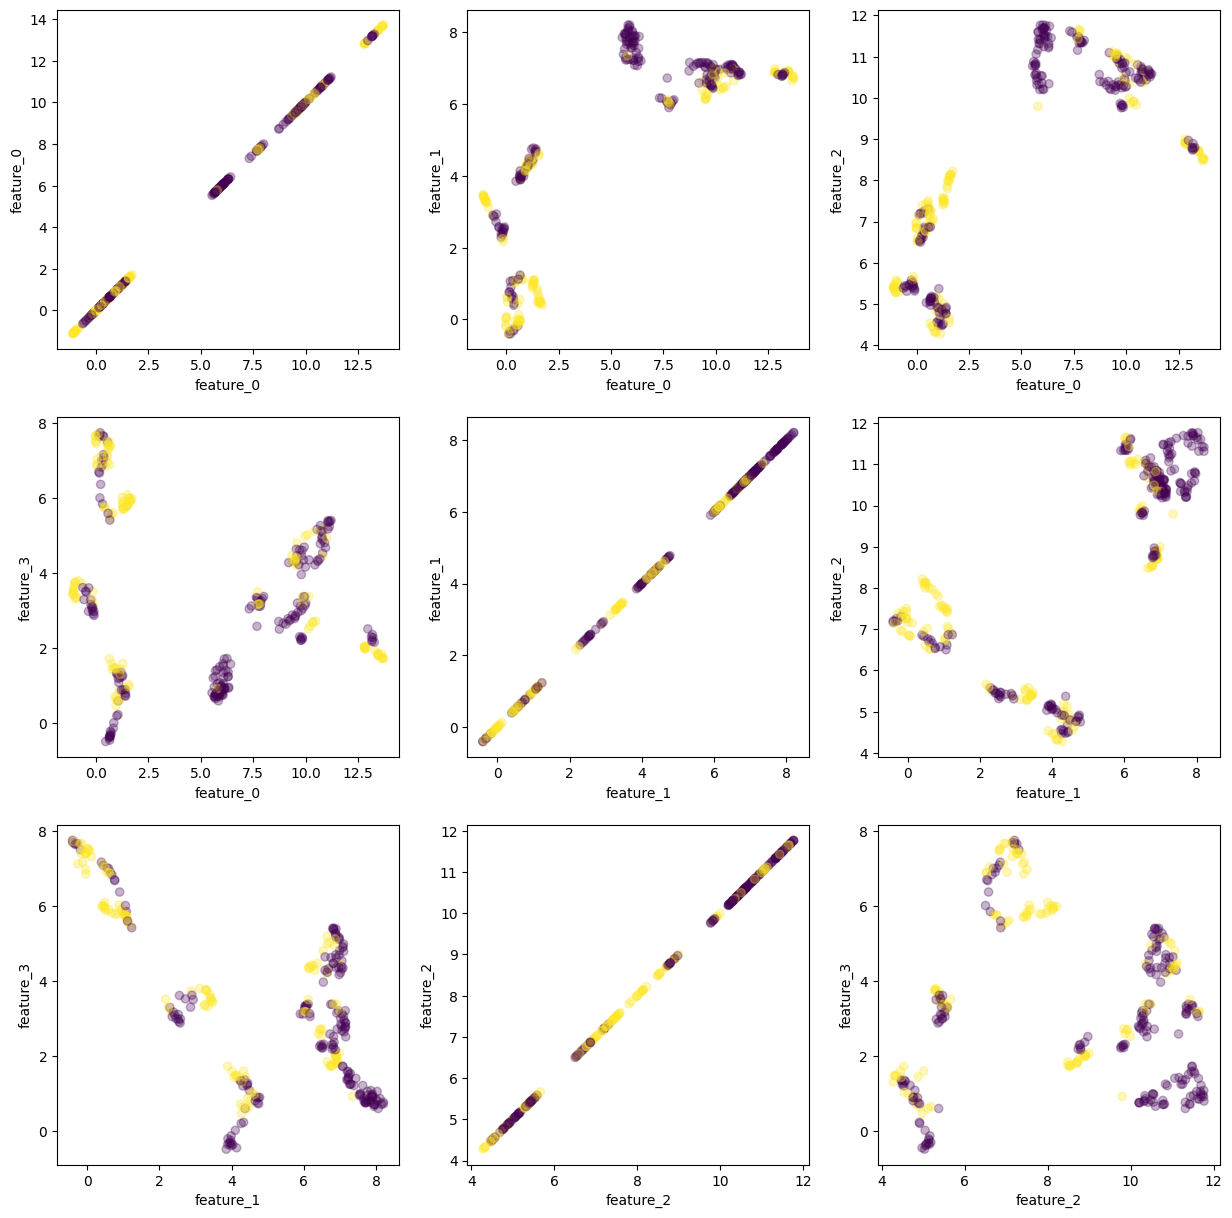

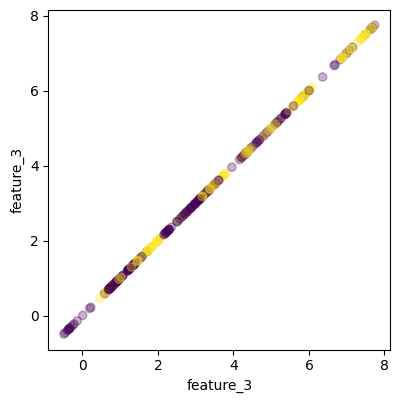

In [117]:
plt.rcParams['figure.figsize'] = [15, 15]

reducer = umaper_new(model, signals_transformed_40_windowed, labels_transformed_40_windowed, n_components=4)

(323, 4)
UMAP, average


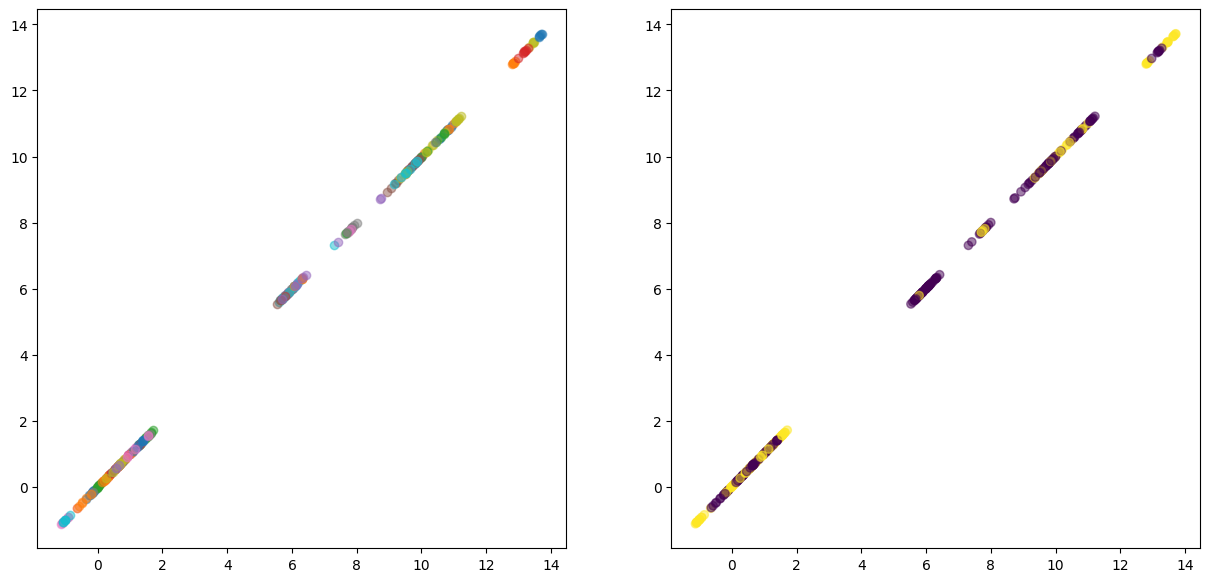

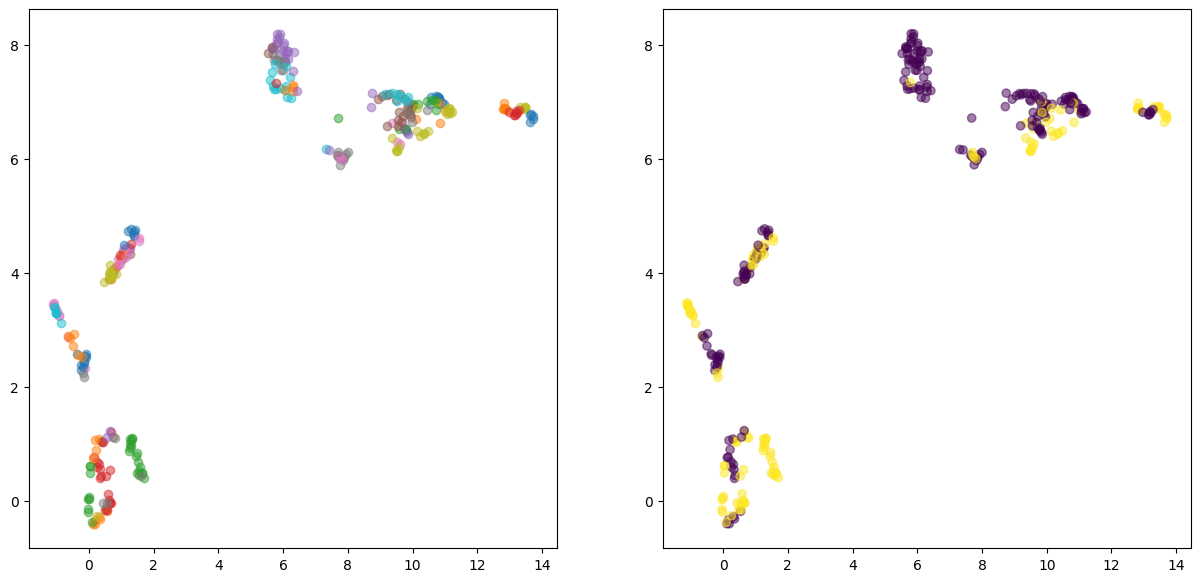

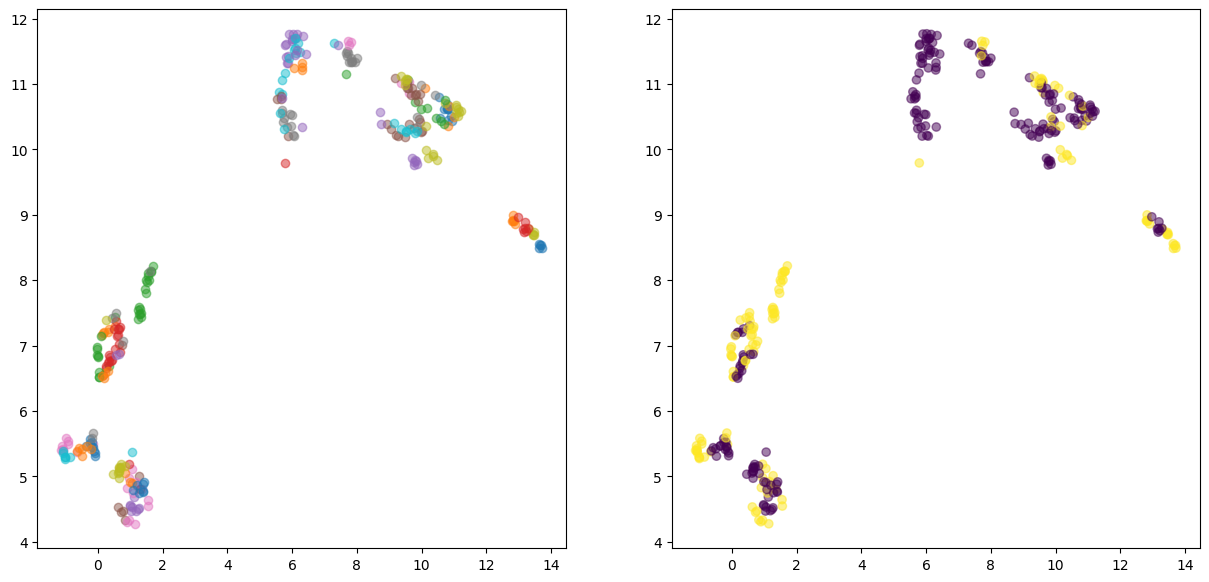

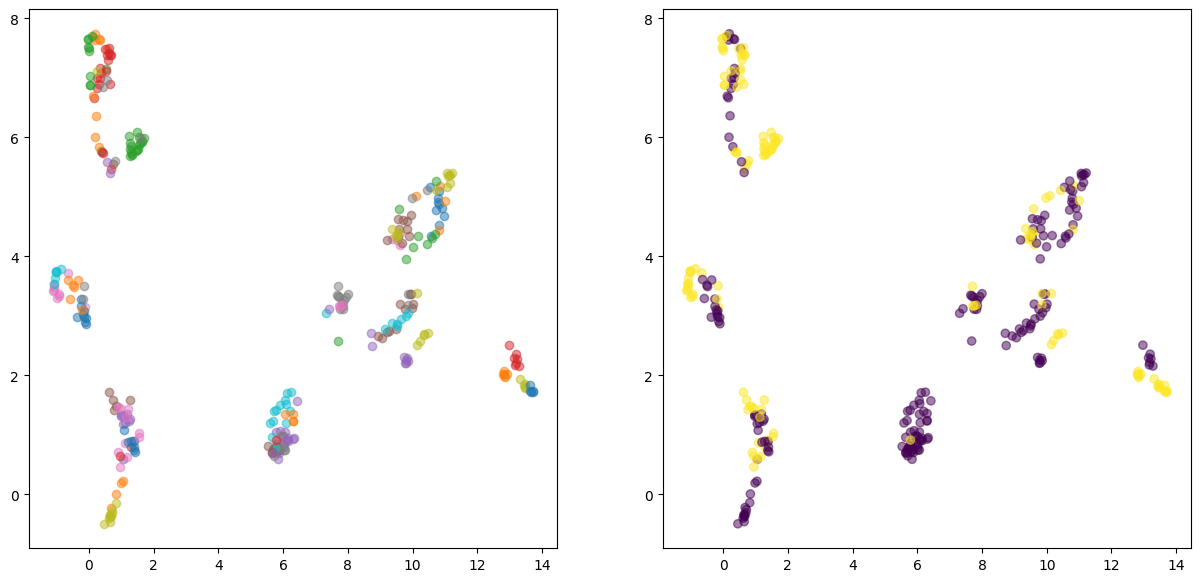

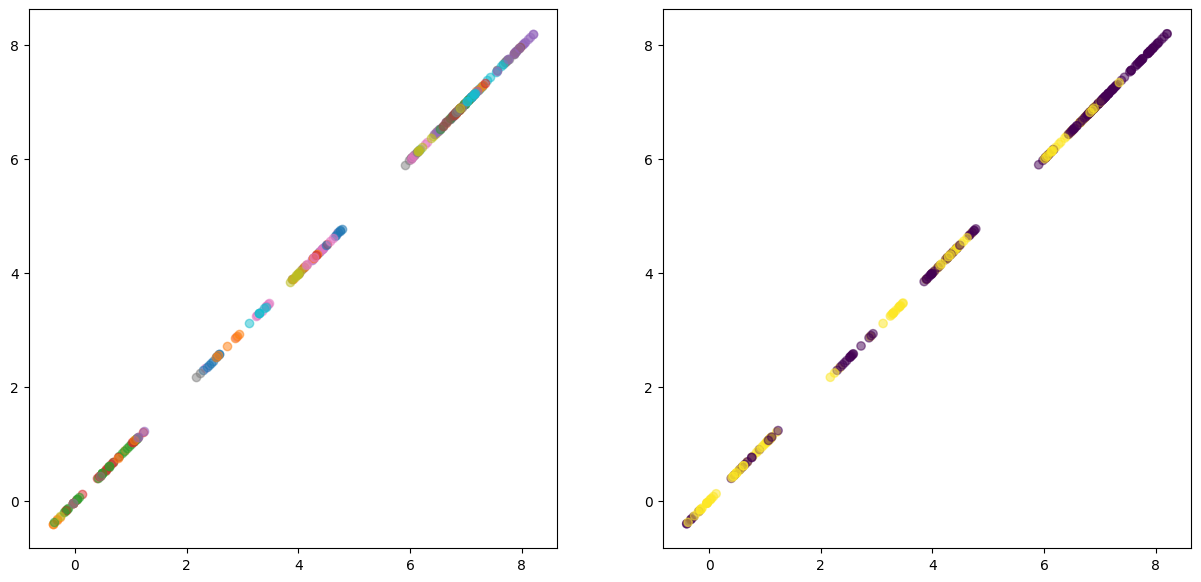

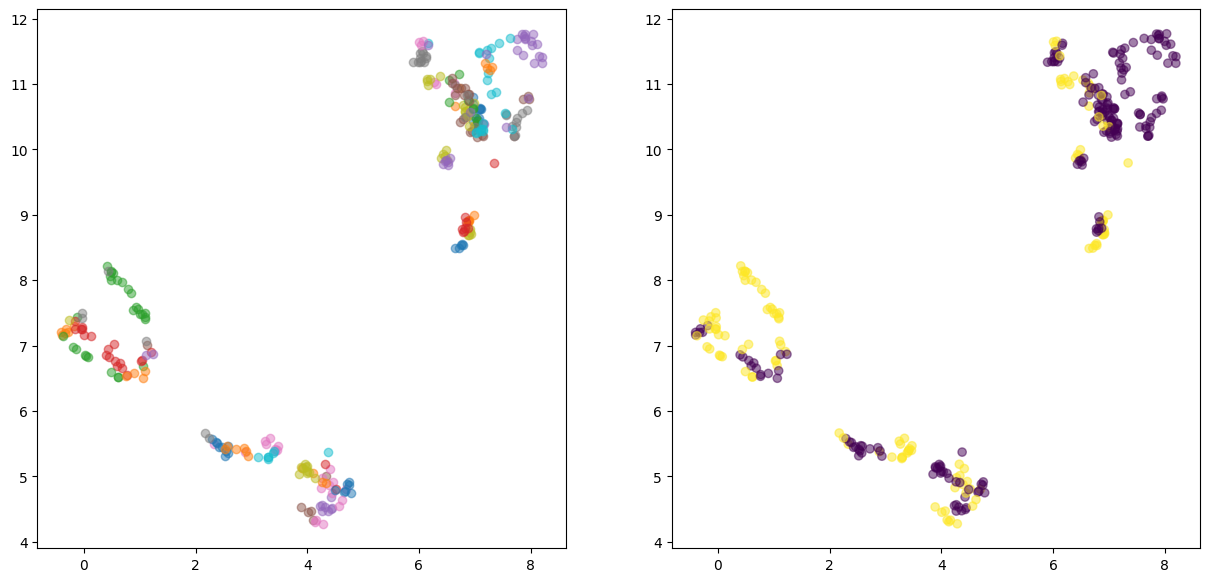

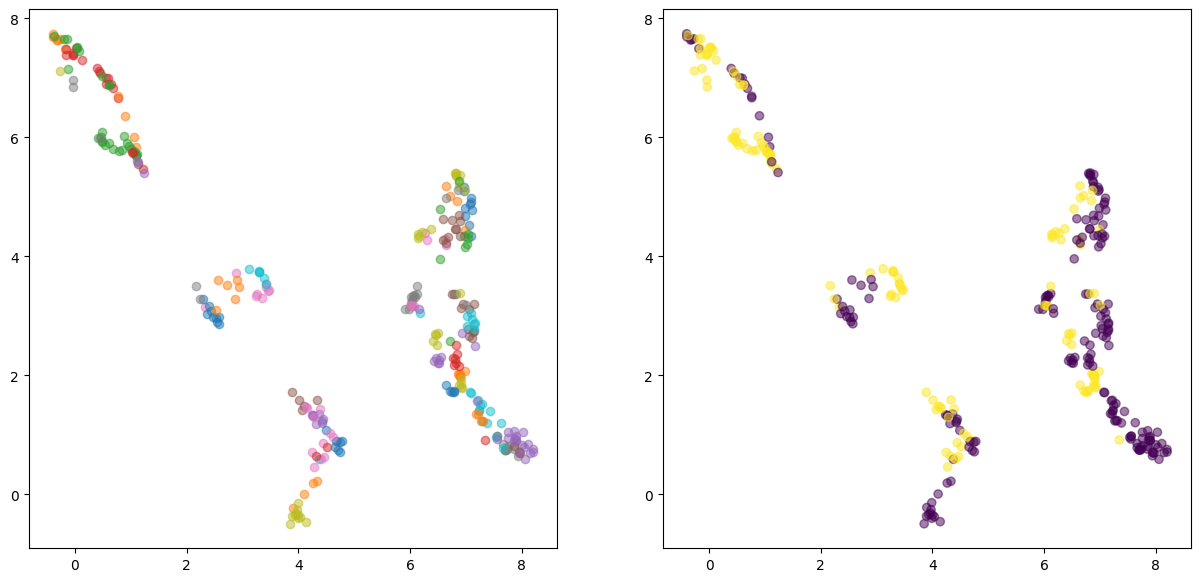

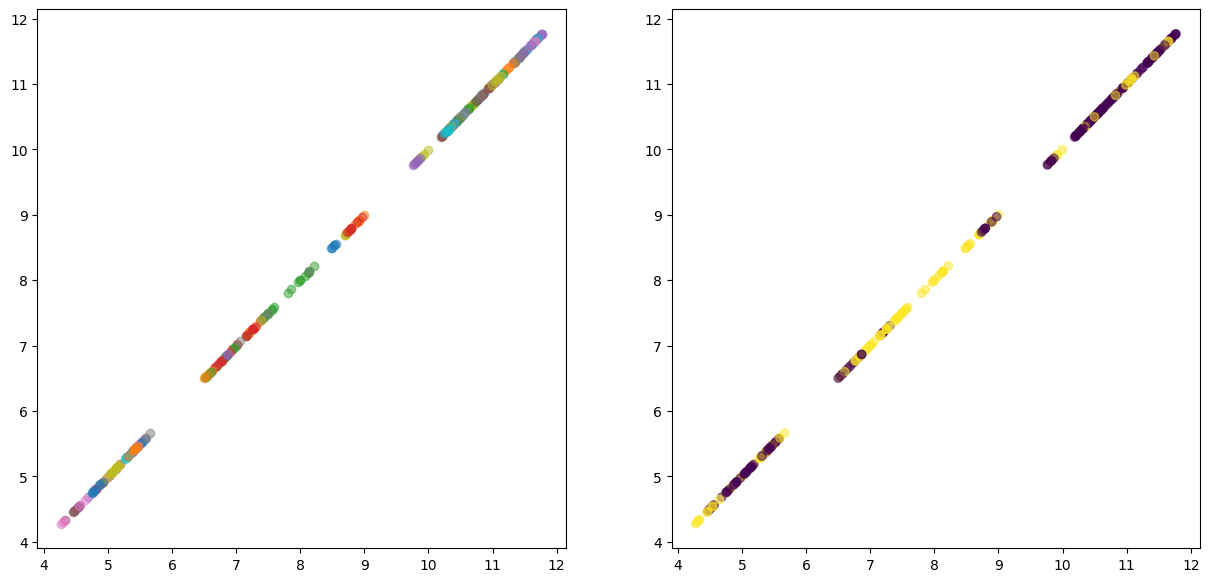

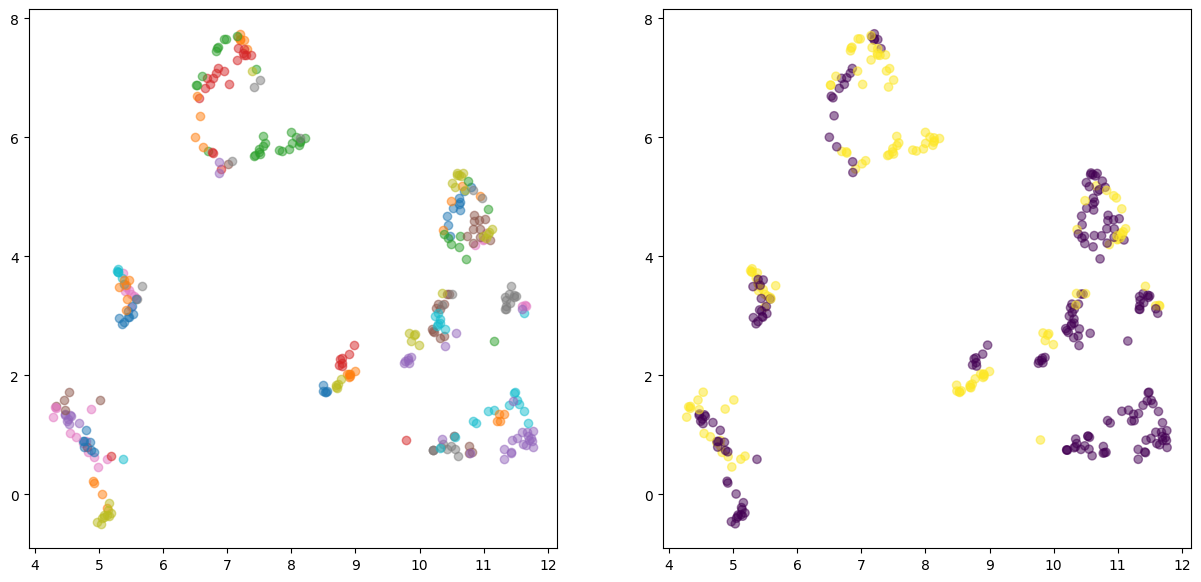

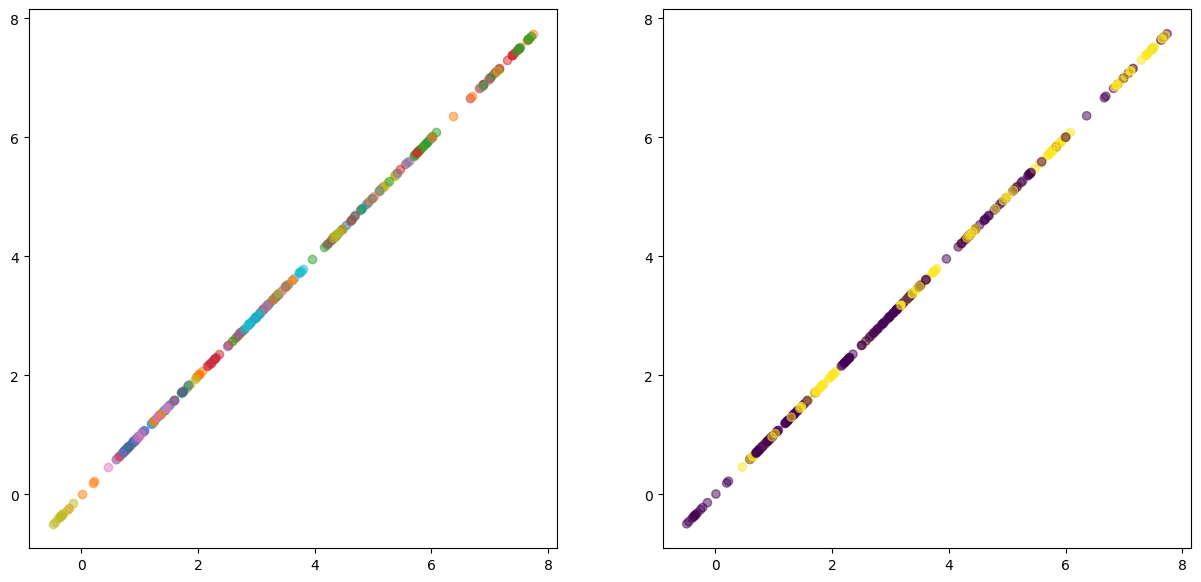

In [118]:
plt.rcParams['figure.figsize'] = [15, 7]
umaper_new_eine(model, signals_transformed_40_windowed, labels_transformed_40_windowed, useable_markers, reducer, 4)

In [119]:
def plot_reconstruction(model, test_data, sample_idx=0):
    model.eval()
    with torch.no_grad():
        sample = test_data[sample_idx]
        reconstructed = model(sample).cpu().numpy()
    
    plt.figure(figsize=(12, 4))
    plt.plot(test_data[sample_idx][0].cpu().numpy(), label="Original")
    plt.plot(reconstructed[0], label="Reconstructed", alpha=0.7)
    plt.legend()
    plt.title("ECG Reconstruction")
    plt.show()

def plot_attention(model, test_data, window_size, sample_idx=0):
    model.eval()
    sample = test_data[sample_idx]
    encoded = model.encoder(sample)
    
    # Получение весов внимания
    Q = model.encoder.attention.query(encoded)
    K = model.encoder.attention.key(encoded)
    scores = torch.matmul(Q, K.transpose(1, 2)) / torch.sqrt(torch.tensor(encoded.shape[-1]))
    weights = torch.softmax(scores, dim=-1).mean(dim=1).squeeze().detach().cpu().numpy()  # Добавлен .detach()
    
    plt.figure(figsize=(12, 4))
    plt.plot(test_data[sample_idx][0].cpu().numpy(), label="ECG")
    plt.imshow(weights[np.newaxis, :], cmap="hot", aspect="auto", alpha=0.5, extent=(0, window_size, -3, 3))
    plt.colorbar(label="Attention Weight")
    plt.title("Attention Map")
    plt.show()

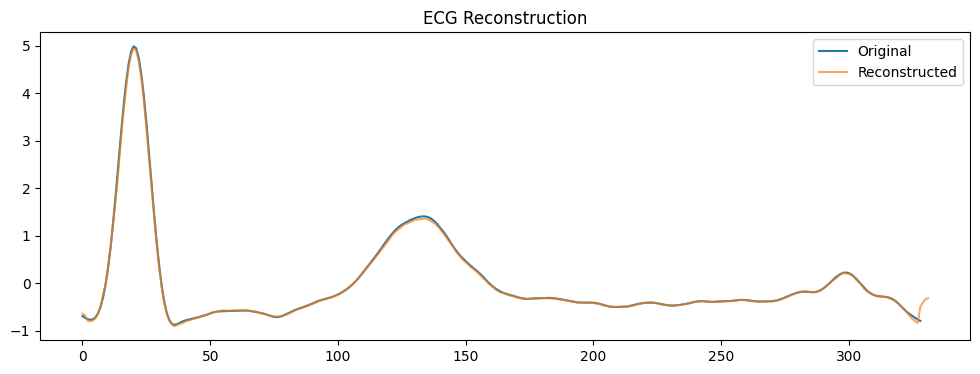

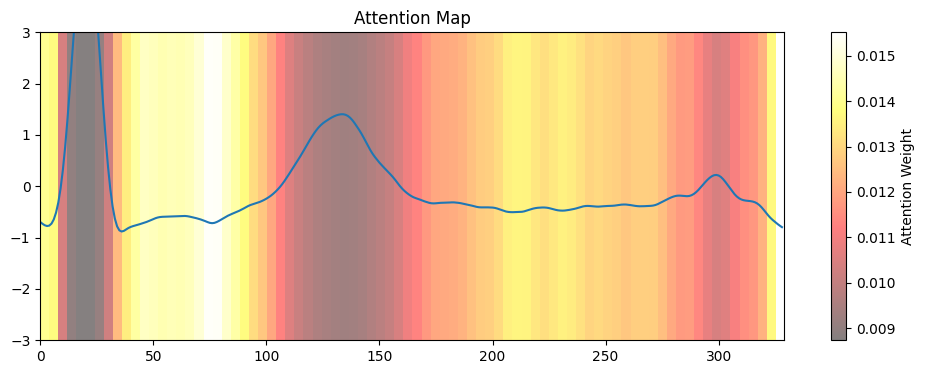

In [137]:
n = 40

plot_reconstruction(model, signals_transformed_40_windowed, sample_idx=n)
plot_attention(model, signals_transformed_40_windowed, len(signals_transformed_40_windowed[n][0]), sample_idx=n)